average rating: 4.065217391304348
calulated rating: 4.060912952587795
actual rating: 3.0


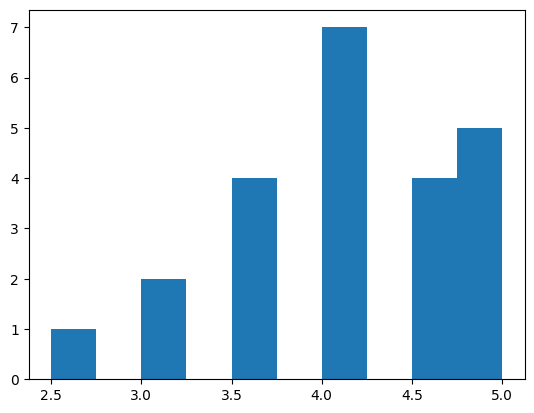

average rating: 4.065217391304348
calulated rating: 4.056289938328501
actual rating: 3.0


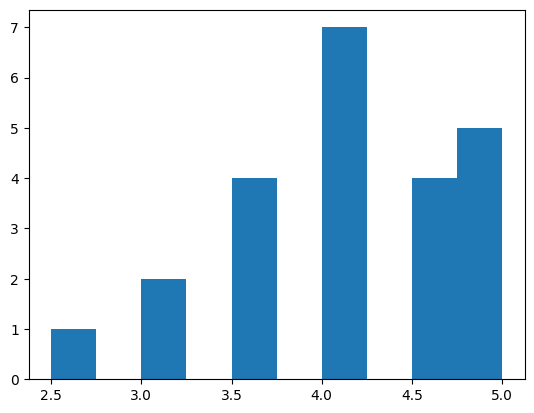

In [18]:
import pandas as pd
from scipy import sparse
import pandas as pd
import numpy as np
from numpy import var
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib import pyplot as plt
from scipy.stats import norm
import numpy as np
from fitter import Fitter, get_common_distributions, get_distributions
from scipy import stats
from scipy.stats import norm


#load data
ratings = pd.read_csv('dataset/ratings.csv')
moviesPartial = pd.read_csv('dataset/movies.csv')
moviesFull = pd.read_csv('dataset/movie_dataset.csv')

#drop duplicates
moviesFull.drop_duplicates(subset = 'title', inplace=True)

#drop columns that do nothing
ratings = ratings.drop(['timestamp'], axis = 1)
moviesPartial = moviesPartial.drop(['genres'],axis=1)

#two users ratings to be tested
firstUserRatings  = ratings[ratings['userId'] ==2]
secondUserRating = ratings[ratings['userId'] ==2]

#remove the year and keep the name
moviesPartial['title'] = moviesPartial['title'].map(lambda string: string[:-7])

#drop duplicates
moviesPartial.drop_duplicates(subset = 'title', inplace=True)


#helper functions:
def get_title_from_movieId(tmp):
    return moviesPartial[moviesPartial["movieId"]== tmp]["title"].to_string(index=False)
def checkTitle(tmp):
    if(tmp not in list(moviesFull["title"])):
        #The word "the" is being apended to the ends of titles
        tmp = tmp[-3:] +" "+ tmp[:-5]
        return moviesFull[moviesFull["title"] == tmp]["title"].to_string(index=False)
    else:
        return moviesFull[moviesFull["title"] == tmp]["title"].to_string(index=False)


firstUserTitles = []
newFirstUserRatings = []
for rating, id in zip(list(firstUserRatings["rating"]), list(firstUserRatings["movieId"])):
    title = get_title_from_movieId(id)
    checked = checkTitle(title)
    if(checked != 'Series([], )'):
        firstUserTitles.append(checked)
        newFirstUserRatings.append(rating)


secondUserTitles = []
newSecondUserRating = []
for rating, id in zip(list(secondUserRating["rating"]), list(secondUserRating["movieId"])):
    title = get_title_from_movieId(id)
    checked = checkTitle(title)
    if(checked != 'Series([], )'):
        secondUserTitles.append(checked)
        newSecondUserRating.append(rating)




fullInfo1 = pd.DataFrame(columns = list(moviesFull.columns))
fullInfo2 = pd.DataFrame(columns = list(moviesFull.columns))


i = 0
for name in firstUserTitles:
    if(len(moviesFull[moviesFull["title"] == name]) !=0):
        fullInfo1.loc[i] = moviesFull[moviesFull["title"] == name].iloc[0]
    i+=1

i = 0
for name in secondUserTitles:
    if(len(moviesFull[moviesFull["title"] == name]) !=0):
        fullInfo2.loc[i] = moviesFull[moviesFull["title"] == name].iloc[0]
    i+=1


features = ['keywords','cast','genres','director']

for feature in features:
    fullInfo1[feature] = fullInfo1[feature].fillna('')
colNumbers1 = []
for feature in features:   
    colNumbers1.append(fullInfo1.columns.get_loc(feature))
fullData1 = []
for index, row in fullInfo1.iterrows():
    temp = []
    for i in range(len(fullInfo1.columns)):
        temp.append(row[i])
    fullData1.append(temp)


for feature in features:
    fullInfo2[feature] = fullInfo2[feature].fillna('')
colNumbers2 = []
for feature in features:   
    colNumbers2.append(fullInfo2.columns.get_loc(feature))
fullData2 = []
for index, row in fullInfo2.iterrows():
    temp = []
    for i in range(len(fullInfo2.columns)):
        temp.append(row[i])
    fullData2.append(temp)



combined_features1 = []
index =0
for row in fullData1:
    #fullData1[index].append(row[colNumbers1[0]]+" "+row[colNumbers1[1]]+" "+row[colNumbers1[2]]+" "+row[colNumbers1[3]])
    combined_features1.append(row[colNumbers1[0]]+" "+row[colNumbers1[1]]+" "+row[colNumbers1[2]]+" "+row[colNumbers1[3]])
    index+=1
# testDataSet = fullData1[0:int(len(fullData1)/2)]
# trainDataSet = fullData1[int(len(fullData1)/2):len(fullData1)]



combined_features2 = []
index =0
for row in fullData2:
    #fullData2[index].append(row[colNumbers2[0]]+" "+row[colNumbers2[1]]+" "+row[colNumbers2[2]]+" "+row[colNumbers2[3]])
    combined_features2.append(row[colNumbers2[0]]+" "+row[colNumbers2[1]]+" "+row[colNumbers2[2]]+" "+row[colNumbers2[3]])
    index+=1
# testDataSet = fullData2[0:int(len(fullData2)/2)]
# trainDataSet = fullData2[int(len(fullData2)/2):len(fullData2)]



cv = CountVectorizer() 
count_matrix = cv.fit_transform(combined_features1)
cosine_sim = cosine_similarity(count_matrix)
average = sum(newFirstUserRatings[1:])/(len(newFirstUserRatings)-1)
print("average rating:",average)
similairities = list(cosine_sim[0])[1:]
ratings = newFirstUserRatings[1:]
sim_sum = sum(similairities)

totalRating = 0
for sim, rating in zip(similairities, ratings):
    totalRating += (sim/sim_sum)*(rating)
print("calulated rating:", totalRating)
print("actual rating:", newFirstUserRatings[0])

plt.hist(ratings, 10)
plt.show()
# f = Fitter(ratings,distributions=['gamma','lognorm',"beta", "burr","norm"])
# f.fit()
# f.summary()


cv = CountVectorizer() 
count_matrix = cv.fit_transform(combined_features2)
cosine_sim = cosine_similarity(count_matrix)
average = sum(newSecondUserRating[1:])/(len(newSecondUserRating)-1)
print("average rating:",average)
similairities = list(cosine_sim[0])[1:]
ratings = newSecondUserRating[1:]

scores = stats.zscore(ratings)
# p_values = norm.sf(scores)
# inverted1 = [1-item for item in p_values]
# tot1 = sum(inverted1)
# p_values = norm.sf(ratings)
# inverted2 = [1-item for item in p_values]
# tot2 = sum(inverted2)

totalRating = 0


#score should be valued based how unique it is
#compare tail end with other point
#-3 is worth alot less than -2
#and 3 is worth alot more than 2

for score, sim in zip(scores, similairities):
    totalRating += (sim)*(score)

print("calulated rating:", average+totalRating)
print("actual rating:", newSecondUserRating[0])

plt.hist(ratings, 10)
plt.show()
# f = Fitter(ratings,distributions=['gamma','lognorm',"beta", "burr","norm"])
# f.fit()
# f.summary()


